In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import stumpy
#import operator
#import time
import pandas as pd
#import scipy.stats as st
#from scipy.integrate import quad
#from sortedcontainers import SortedDict
import staircase as sc

# Some imports to get us active
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings("ignore")

#from numba import vectorize
from hotstep.Basis import Basis
from hotstep.Step import Step
from hotstep.Steps import Steps
from hotstep.Steps import Analysis


In [7]:
# my pacf function
def my_pacf(data, maxlags=None):
    
    betas = []

    if (maxlags is None) or (maxlags >= len(data)):
        maxlags = len(data) - 1 
        
    pacf = np.empty(maxlags + 1)
    pacf[0] = 1.0
    
    xlags, x0 = lagmat(data, maxlags, original="sep")
    xlags = add_constant(xlags)

    for lag in range(1, maxlags + 1):
        params = np.linalg.lstsq(xlags[lag:, : lag + 1], x0[lag:], rcond=None)[0]
        pacf[lag] = params[-1]
        betas.append([lag, params])
        
    return pacf,betas


In [5]:
df = pd.read_csv(r"data/vessel_queue.csv", parse_dates=['enter', 'leave'], dayfirst=True)

df.enter = df.enter.apply(pd.Timestamp)
df.leave = df.leave.apply(pd.Timestamp)

vsteps = Steps.stepify(df,'enter','leave')



<BarContainer object of 201 artists>

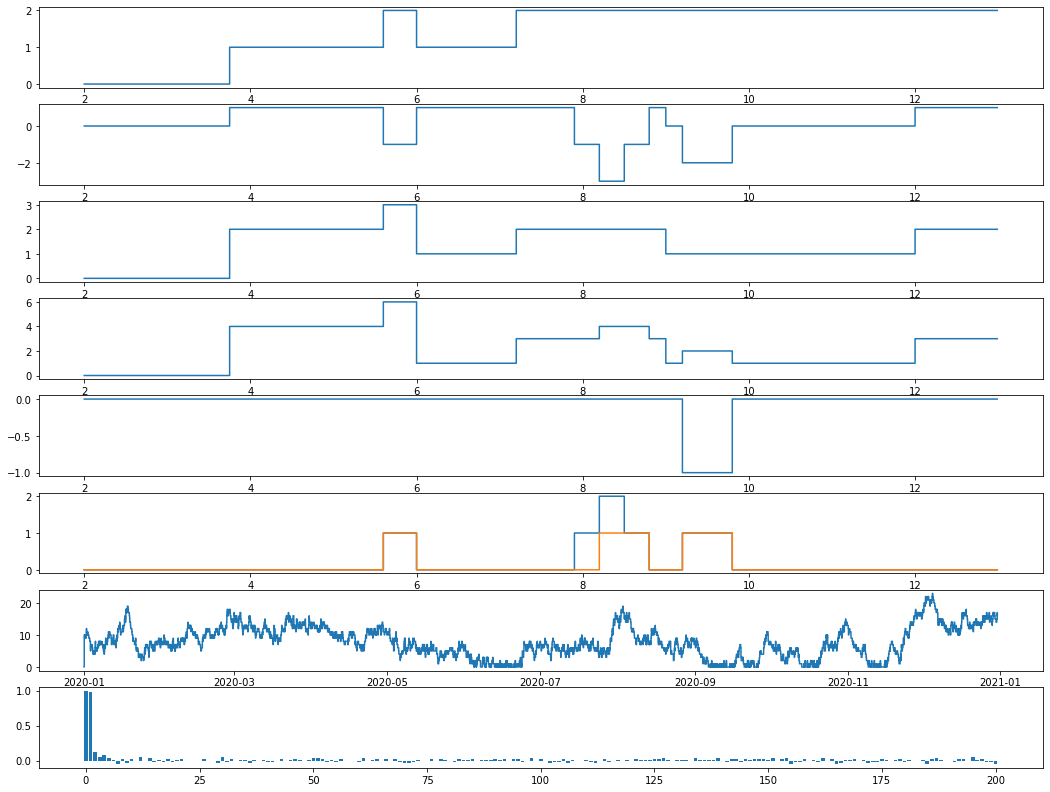

In [8]:

tbase = Basis(Basis.sigmoid,5)


x = Step(3.75)
y = Step(5.6,6)
y2 = Step(8.2,8.8)
y3 = Step(9.2,9.8)

#y3.rebase()
z = Step(7.2)
q = Step(12)

p = Step(9,weight=-1)
p1 = Step(9.5,weight=-1)

ss1 = Steps()
ss1 = ss1.add([z,x,y])

ss2 = Steps()
ss2 = ss2.add([q,x,p])

s1 = sc.Stairs()
s1.layer(4)
s1.layer(5,6)
s1.layer(4)
s1.layer(7)
s1.layer(12)
s1.layer(9,value=-1)

ss3 = Steps().add([Step(4),Step(4),Step(5,6),Step(7),Step(12),Step(9,weight=-1)])

y4 = y2 << 0.3
ss3 = ss2 + ss1
ss4 = ss3+y2
ss4 += y3

ss5 = Steps().add([y2,y3])

yy =  y+y2+y3 + y4
#yy -=ss2
#yy.rebase(Basis(Basis.logit))
#ss4.rebase(tbase)
    
p = np.arange(2,13,0.01)

fig,ax = plt.subplots(nrows=8,figsize=(18,14))

ax[0].step(p,ss1[p])
ax[1].step(p,(ss2-yy-yy).step(p))
ax[2].step(p,ss3.step(p))
#s1.plot(ax[2],color='r')
ax[3].step(p,(ss4+ss3).step(p))
#ax[3].step(p,(ss4 > 0).step(p))
#ax[3].step(p,(ss4 > 2).step_function(p),color='r')
#ax[5].step(p,ss5.step_function(p))
#ax[5].step(p,(y4 << 4).step(p))
#ax[5].step(p,y4[p])
ax[5].step(p,yy.step(p))
ax[5].step(p,(yy-y4).step(p))

ax[4].step(p,y3.reflect().step(p))

st_pac = (ss2-yy-yy)
#st_pac_dict = st_pac.to_dict()
pac,bet = my_pacf(vsteps.step_values(),200)
vsteps.plot(ax=ax[6])

ax[7].bar(list(range(len(pac))),pac)
#print(st_pac.step_values())


In [ ]:
#[2, 3, 1, 2, 1, 2]
#[3.75, 5.6, 6, 7.2, 9, 12]

s1 = sc.Stairs()
s1.layer(4)
s1.layer(4)
s1.layer(5,6)
s1.layer(7)
s1.layer(12)
s1.layer(9,value=-1)

ss3 = Steps().add([Step(4),Step(4),Step(5,6),Step(7),Step(12),Step(9,weight=-1)])

s = Step(4,weight=2)
tbase = Basis(Basis.logit,1)
ss3.rebase()
#print(s.integrate(10,0))
print(Analysis.mean_integrate2(ss3))
#print(list(ss3._cummulative.keys()))

print(s1.integrate())

In [ ]:
queue = sc.Stairs(use_dates=True).layer(df.enter, df.leave)
